# Train Bounding Box model

This notebook trains a model to take in six images from the car's point of view, and output a bird's eye view of the bouding boxes around surrounding objects. 



In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [3, 3]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#!conda install -c conda-forge opencv -y
import cv2 
from yolov3 import *


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
device

device(type='cuda', index=0)

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [4]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/bs3743/DL-TopDownRoad/data'
annotation_csv = '/scratch/bs3743/DL-TopDownRoad/data/annotation.csv'

### Read in the labeled training data, and split into a training and validation set

In [5]:
# The scenes from 106 - 133 are labeled
labeled_scene_index = np.arange(106, 134)

In [6]:
# Split 75/25 into training and validation
random.shuffle(labeled_scene_index)
labeled_scene_index_train = labeled_scene_index[0:21]
labeled_scene_index_val = labeled_scene_index[21:28]
print("Train scenes: {} \nVal scenes: {}".format(len(labeled_scene_index_train), len(labeled_scene_index_val)))

Train scenes: 21 
Val scenes: 7


In [7]:
transform = torchvision.transforms.ToTensor()

In [8]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index_train,
                                  transform=transform,
                                  extra_info=False
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [47]:
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index_val,
                                  transform=transform,
                                  extra_info=False
                                 )
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [10]:
sample, target, road_image = iter(trainloader).next()
print(torch.stack(sample).shape)
#print(torch.stack(sample)[:, 1, :, :].shape)

torch.Size([2, 6, 3, 256, 306])


### Train the model

In [11]:
# Create model config

config = "yolov3-spp.cfg"
hyp = {'giou': 3.54,  # giou loss gain
       'cls': 2.4,  # cls loss gain
       'cls_pw': 1.0,  # cls BCELoss positive_weight
       'obj': 64.3,  # obj loss gain (*=img_size/320 if img_size != 320)
       'obj_pw': 1.0,  # obj BCELoss positive_weight
       'iou_t': 0.20,  # iou training threshold
       'lr0': 10e-5,  # initial learning rate (SGD=5E-3, Adam=5E-4)
       'lrf': 5e-7,  # final learning rate (with cos scheduler)
       'momentum': 0.937,  # SGD momentum
       'weight_decay': 0.000484,  # optimizer weight decay
       'fl_gamma': 0.0,  # focal loss gamma (efficientDet default is gamma=1.5)
       'hsv_h': 0.0138,  # image HSV-Hue augmentation (fraction)
       'hsv_s': 0.678,  # image HSV-Saturation augmentation (fraction)
       'hsv_v': 0.36,  # image HSV-Value augmentation (fraction)
       'degrees': 1.98 * 0,  # image rotation (+/- deg)
       'translate': 0.05 * 0,  # image translation (+/- fraction)
       'scale': 0.05 * 0,  # image scale (+/- gain)
       'shear': 0.641 * 0}  # image shear (+/- deg)

In [13]:
# Initialize model

model = Darknet(config, verbose=False).to(device)
#ONNX_EXPORT = False


Model Summary: 225 layers, 6.25777e+07 parameters, 6.25777e+07 gradients


In [14]:
# Intialize optimizer
pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
for k, v in dict(model.named_parameters()).items():
    if '.bias' in k:
        if v.is_leaf:
            pg2 += [v]  # biases
    elif 'Conv2d.weight' in k:
        pg1 += [v]  # apply weight_decay
    else:
        pg0 += [v]  # all else

optimizer = optim.Adam(pg0, lr=hyp['lr0'])
optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
del pg0, pg1, pg2

In [15]:
# Create training function
def train(train_loader, model, optimizer, criterion, epoch, sixinput):
    
    model.train()

    for batch_idx, (sample, target, road_image) in enumerate(train_loader):

        # Rework target into expected format:
        # A tensor of size [B, 6]
        # where B is the total # of bounding boxes for all observvations in the batch 
        # and 6 is [id, class, x, y, w, h] (class is always 0, since we're not doing classification)
        # Target is originally front left, front right, back left and back right
        # Note: for boxes not aligned with the x-y axis, this will draw a box with the same center but a maximal width-height that *is* aligned
        # The original range is xy values from from -40 to 40. We also rescale so that x values are from 0 to 1
        target_yolo = torch.zeros(0,6)
        for i, obs in enumerate(target):
            boxes = (obs['bounding_box'] + 40)/80
            boxes_yolo = torch.zeros(boxes.shape[0], 6)
            for box in range(boxes.shape[0]):
                cls = 0
                x_center = 0.5*(boxes[box, 0, 0] + boxes[box, 0, 3])
                y_center = 0.5*(boxes[box, 1, 0] + boxes[box, 1, 3])
                width = max(boxes[box, 0, :]) - min(boxes[box, 0, :])
                height = max(boxes[box, 1, :]) - min(boxes[box, 1, :])
                boxes_yolo[box] = torch.tensor([i, cls, x_center, y_center, width, height])
            target_yolo = torch.cat((target_yolo, boxes_yolo), 0)

        # Send to device
        sample = torch.stack(sample).to(device)
        target_yolo = target_yolo.to(device)

        # Make input the correct shape
        if sixinput==False:
            batch_size = sample.shape[0]
            sample = sample.view(batch_size, -1, 256, 306) # torch.Size([3, 18, 256, 306])

        # Run through model
        optimizer.zero_grad()
        output = model(sample)

        # Calculate loss and take step
        loss, loss_items = compute_loss(output, target_yolo, model, hyp) # Note: this is defined in yolov3.py
        if not torch.isfinite(loss):
            print('WARNING: non-finite loss.')
        loss.backward()
        optimizer.step()

        # Log progress
        if batch_idx % 100 == 0:
            print('\tTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                
    return


In [16]:
# Create an evaluation function
def evaluate(val_loader, model, sixinput):
    model.eval()
    losses = []
    tp, fp, fn = 0, 0, 0
    for batch_idx, (sample, target, road_image) in enumerate(val_loader):
        
        # Rework target into expected format:
        # A tensor of size [B, 6]
        # where B is the total # of bounding boxes for all observvations in the batch 
        # and 6 is [id, class, x, y, w, h] (class is always 0, since we're not doing classification)
        # Target is originally front left, front right, back left and back right
        # Note: for boxes not aligned with the x-y axis, this will draw a box with the same center but a maximal width-height that *is* aligned
        # The original range is xy values from from -40 to 40. We also rescale so that x values are from 0 to 1
        # "Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height."
        target_yolo = torch.zeros(0,6)
        for i, obs in enumerate(target):
            boxes = (obs['bounding_box'] + 40)/80
            boxes_yolo = torch.zeros(boxes.shape[0], 6)
            for box in range(boxes.shape[0]):
                cls = 0
                x_center = 0.5*(boxes[box, 0, 0] + boxes[box, 0, 3])
                y_center = 0.5*(boxes[box, 1, 0] + boxes[box, 1, 3])
                width = max(boxes[box, 0, :]) - min(boxes[box, 0, :])
                height = max(boxes[box, 1, :]) - min(boxes[box, 1, :])
                boxes_yolo[box] = torch.tensor([i, cls, x_center, y_center, width, height])
            target_yolo = torch.cat((target_yolo, boxes_yolo), 0)
        
        # Send to device
        sample = torch.stack(sample).to(device)
        target_yolo = target_yolo.to(device)
         
        # Make input the correct shape
        if sixinput==False:
            batch_size = sample.shape[0]
            sample = sample.view(batch_size, -1, 256, 306) # torch.Size([3, 18, 256, 306])
        
        # Run through model
        with torch.no_grad():
            output = model(sample)
        # Calculate loss
        #print(output[0].shape)
        loss, loss_items = compute_loss(output[1], target_yolo, model, hyp) # Note: this is defined in yolov3.py
        losses.append(loss)
    
    # Calculate metrics
    loss = sum(losses)/len(losses)
    
    return loss


In [ ]:
# Train
min_val_loss = np.inf
#val_threat_score_hist = []
val_loss_hist = []

for epoch in range(30):
    
    # Train for one epoch
    train(trainloader, model, optimizer, None, epoch, sixinput=False)
    
    # Evaluate at the end of the epoch
    print("Evaluating after Epoch {}:".format(epoch))
    #val_loss, val_threat_score = evaluate(valloader, model, loss, sixinput=False)
    #print("Val loss is {:.6f}, threat score is {:.6f}".format(val_loss, val_threat_score))
    model.training= False
    val_loss = evaluate(valloader, model, sixinput=False)
    model.training=True
    print("Val loss is {}".format(val_loss.cpu().detach()))
    
    # If this is the best model so far, save it
    if val_loss < min_val_loss:
        torch.save({
            'epoch': epoch,
            'config': config,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            }, 'models/best_bounding_box_10e-5_5e-7.pt')
    
    # Save loss 
    val_loss_hist.append(val_loss)
    #val_threat_score_hist.append(val_threat_score)

checkpoint = torch.load('models/best_bounding_box_10e-5_5e-7.pt')
checkpoint['val_loss_hist'] = val_loss_hist
#checkpoint['val_threat_score_hist'] = val_threat_score_hist
torch.save(checkpoint, 'models/best_bounding_box_10e-5_5e-7.pt')

	Train Epoch: 0 [0/2646 (0%)]	Loss: 10.482500
	Train Epoch: 0 [200/2646 (8%)]	Loss: 4.753625
	Train Epoch: 0 [400/2646 (15%)]	Loss: 5.928028
	Train Epoch: 0 [600/2646 (23%)]	Loss: 9.264941
	Train Epoch: 0 [800/2646 (30%)]	Loss: 3.878227
	Train Epoch: 0 [1000/2646 (38%)]	Loss: 3.273087
	Train Epoch: 0 [1200/2646 (45%)]	Loss: 3.464520
	Train Epoch: 0 [1400/2646 (53%)]	Loss: 6.097253
	Train Epoch: 0 [1600/2646 (60%)]	Loss: 7.616407
	Train Epoch: 0 [1800/2646 (68%)]	Loss: 6.397943
	Train Epoch: 0 [2000/2646 (76%)]	Loss: 3.962619
	Train Epoch: 0 [2200/2646 (83%)]	Loss: 3.332586
	Train Epoch: 0 [2400/2646 (91%)]	Loss: 4.565530
	Train Epoch: 0 [2600/2646 (98%)]	Loss: 4.344994
Evaluating after Epoch 0:
Val loss is tensor([5.07001])
	Train Epoch: 1 [0/2646 (0%)]	Loss: 5.350194
	Train Epoch: 1 [200/2646 (8%)]	Loss: 2.228661
	Train Epoch: 1 [400/2646 (15%)]	Loss: 4.805711
	Train Epoch: 1 [600/2646 (23%)]	Loss: 6.353627
	Train Epoch: 1 [800/2646 (30%)]	Loss: 5.453632
	Train Epoch: 1 [1000/2646 (38

In [49]:
# Show hyperparameter tuning results
for i in [4, 5, 6]:
    path = 'models/best_bounding_box_10e-{}_5e-7.pt'.format(str(i))
    checkpoint = torch.load(path)
    print(path)
    print("Best val loss: {}\n".format(checkpoint['val_loss']))

models/best_bounding_box_10e-4_5e-7.pt
Best val loss: tensor([4.91705], device='cuda:0')

models/best_bounding_box_10e-5_5e-7.pt
Best val loss: tensor([6.75921], device='cuda:0')

models/best_bounding_box_10e-6_5e-7.pt
Best val loss: tensor([5.53980], device='cuda:0')



In [13]:
# Read in a saved model
checkpoint = torch.load('models/best_bounding_box_10e-5_5e-7.pt')
model = Darknet(checkpoint['config'], verbose=False).cuda()
model.load_state_dict(checkpoint`['model_state_dict'])
model.eval()

Model Summary: 225 layers, 6.25777e+07 parameters, 6.25777e+07 gradients


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (Conv2d): Conv2d(18, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(64, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (Conv2d): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [46]:
sample, target, road_image = iter(valloader).next()
model.eval()
sample = torch.stack(sample).to(device)

# Make input the correct shape
batch_size = sample.shape[0]
sample = sample.view(batch_size, -1, 256, 306) # torch.Size([3, 18, 256, 306])

ValueError: too many values to unpack (expected 3)

In [41]:
# Run through model
output = model(sample)

# Apply non-max supression
#Returns list of length batch_size, with each list element being a tensor of size nx6 (x1, y1, x2, y2, conf, cls) 
conf_thres = 0.06
iou_thres = 0
output = non_max_suppression(output[0], conf_thres, iou_thres,
                                   multi_label=False, classes=None, )
# Rescale from 306x256 to 80x80 (from -40 to 40)
if output[0] != None:
    for i in range(output[0].shape[0]):
        # Get four corners
        x1=output[0][i][0]
        y1=output[0][i][1]
        x2=output[0][i][2]
        y2=output[0][i][3]
        bounding_boxes[i, :, :] = torch.tensor([[x1, x1, x2, x2],
                                                [y1, y2, y1, y2]])

In [42]:
# Store bounding boxes in the correct format
bounding_boxes = torch.zeros((output[0].shape[0], 2, 4))
#len(output[0])
if output[0] != None:
    for i in range(output[0].shape[0]):
        # Get four corners
        bounding_boxes[i, :, :] = torch.tensor([[output[0][i][0],  output[0][i][2], output[0][i][2],  output[0][i][0]],
                                                [output[0][i][1],  output[0][i][1], output[0][i][3], output[0][i][3]]])
# Truncate corners that are out of range
bounding_boxes[bounding_boxes>40] = 40
bounding_boxes[bounding_boxes<-40] = -40

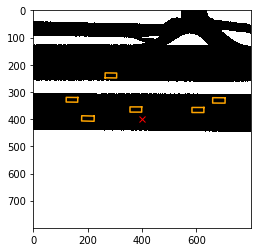

In [43]:
# Plot original
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

IndexError: index 6 is out of bounds for dimension 0 with size 6

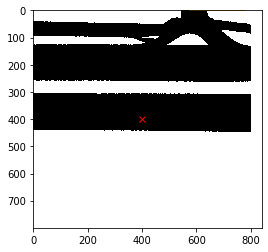

In [44]:
# Plot prediction
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(bounding_boxes):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

In [ ]:
output[1].shape